# HyDaT Tracker (version 1.0)

### Running the HyDaT Tracker 
* Run all cells to execute the program
* [Setup parameters of the background subtraction-based detector](#bgpara)
* [Setup stracking paramerters of HyDaT](#allpara)
* [Go to the Main Program to import video ](mainprogram)
* Create a folder named 'output' in the destination to save tracking data


All the custom made methods required for the program to function is included in this notebook to facilitate the users to edit parameters and methods as necessory.

Importing Dependencies

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from darkflow.net.build import TFNet
import cv2
import xml.etree.cElementTree as ET
import pandas as pd
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import scipy.signal as scipysignal
import matplotlib
import scipy.stats as stats
import warnings; warnings.simplefilter('ignore')
import math
from datetime import datetime

C:\Users\mrat0006\AppData\Local\Continuum\anaconda3\envs\tensorflow_env\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## Setting up YOLOv2 Detection Model

In [2]:
options = {"model": "cfg/yolo_custom.cfg",
           "load": -1}

In [3]:
tfnet2 = TFNet(options)

Parsing cfg/yolo_custom.cfg
Loading None ...
Finished in 0.0s

Building net ...
Source | Train? | Layer description                | Output size
-------+--------+----------------------------------+---------------
Instructions for updating:
Colocations handled automatically by placer.
       |        | input                            | (?, 608, 608, 3)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 608, 608, 32)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 304, 304, 32)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 304, 304, 64)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Init  |  Yep!  | conv 1x1p0_1  +bnorm  leaky      | (?, 152, 152, 64)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 152, 152, 128)
 Load  |  Yep!  | maxp 2x2p0_2                     | (?, 76, 76, 128)
 Init  |  Yep!  | conv 3x3p1_1  +bnorm  leaky      | (?, 76, 76, 256)
 Init 

In [4]:
tfnet2.load_from_ckpt()

Loading from ./ckpt/yolo_custom-12000
INFO:tensorflow:Restoring parameters from ./ckpt/yolo_custom-12000


# Setting up the program

### Setting up Initial Detection

In [5]:
def count_bees_int(_predictions,_minConf):
    _nbees_index = np.zeros(shape=(0,2))
    for result in _predictions:
        confidence = result['confidence']
        if (confidence > _minConf):
            x0,y0 = get_coord_ML(result)
            bee_in_range = in_screen_int(x0, y0)
            if (bee_in_range ==True):
                _nbees_index = np.vstack([_nbees_index,(x0,y0)])

    _nbees = len(_nbees_index) 
    
    return _nbees

def in_screen_int(_xc, _yc):
    _in_screen = False
    if (((_xc>=minX)&(_xc<=maxX))&((_yc>=minY)&(_yc<=maxY))):
        _in_screen = True
        
    return _in_screen

def bee_coordinates_int(_results,_minConf):
    for _result in _results:
        _confidence = _result['confidence']
        
        if (_confidence > _minConf):
            _x, _y = get_coord_ML(_result)
            bee_in_range = in_screen_int(_x, _y)
            
            if (bee_in_range ==True):
                _bee_coordinates_int = np.array([[_x,_y]])
            
    return _bee_coordinates_int 

def detect_from_ML_int(_nframe, _frame, _minConf):
    _frame = np.asarray(_frame)      
    _results = tfnet2.return_predict(_frame)
    _nbees = count_bees_int(_results,_minConf)
    
    return _results, _nbees,_frame

def add_int_record(_track_frame,_bees,nframe):
    xc, yc = _bees[0][0],_bees[0][1]
    newdata = [nframe,xc, yc,np.nan, xc, yc, 0, np.nan, np.nan,'ML',xc,yc,xc,yc,xc,yc,np.nan,np.nan,np.nan,np.nan,np.nan,'Int_detection']
    df.loc[len(df)] = newdata
    df.sx = df.x.rolling(3, min_periods=1).mean()
    df.sy = df.y.rolling(3, min_periods=1).mean()
    cv2.circle(_track_frame, (int(xc), int(yc)), 3, (255, 0, 0), 2)
    
    return _track_frame

### Setup background-subtraction parameters

<a id='bgpara'></a>

In [6]:
#Parameters for background subtraction
min_area_insect = 500 #Minimum area covered by insect (pixels)
max_area_insect = 3000 #Maximum area covered by insect (pixels)
min_area_bgchange = 50 #Minimum area for background change (pixels)
max_area_bgchange = 8000 #Maximum area for background change (pixels)

### Setting up Background Substraction Model

In [7]:
def Extract_cont(frame):
    fgmask = fgbg.apply(frame)
    median = cv2.medianBlur(fgmask,9)
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(median,kernel,iterations = 1)
    image, contours, hier = cv2.findContours(erosion, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

def detect_bees(nframe, bees,bg_changes, c, minframe):
    (x,y), (w, h), _ = rect = cv2.minAreaRect(c)
    area = w*h
    box = cv2.boxPoints(rect)
    box = np.int0(box)
        
    if area > min_area_insect and area<max_area_insect:
        if nframe >=minframe:
            bees = np.vstack([bees,(x,y,area)])
    if area > min_area_bgchange and area<max_area_bgchange:
        if nframe >=minframe:
            bg_changes = np.vstack([bg_changes,(x,y,area)])

    return bees, bg_changes

def check_bg_changes(_bg_changes,_oldbees,_max_jump_ML, _max_bg_changes):
    _change_in_bg = False
    nchanges_in_bg = 0
    to_be_checked = np.arange(0,len(_bg_changes),1)

    for tbc in to_be_checked:
        _this_dist = cal_dist(_bg_changes[tbc][0],_bg_changes[tbc][1],_oldbees[0][0],_oldbees[0][1])
        if (_this_dist <= _max_jump_ML):
            nchanges_in_bg += 1
            if (nchanges_in_bg>_max_bg_changes):
                cv2.putText(details_frame, 'Background Changes Detected' , (1400, 20), cv2.FONT_HERSHEY_DUPLEX , 0.8, (0, 0, 255), 1, cv2.LINE_AA)
                _change_in_bg = True
                
    return _change_in_bg , nchanges_in_bg

### Detection with Deep Learning Model

In [8]:
def get_coord_ML(result):
    _xc,_yc = 0,0
    xmin = str(result['topleft']['x'])
    ymin = str(result['topleft']['y'])
    xmax = str(result['bottomright']['x'])
    ymax = str(result['bottomright']['y'])
    _xc = ((int(xmin)+int(xmax))/2)
    _yc = ((int(ymin)+int(ymax))/2)    

    return _xc,_yc

        
def bee_coordinates(_results,_minConf):
    _bee_coordinates = np.zeros(shape=(0,2))
    for _result in _results:
        _confidence = _result['confidence']
        if (_confidence > _minConf):
            _x, _y = get_coord_ML(_result)
            _bee_coordinates = np.vstack([_bee_coordinates,(_x,_y)]) 
            
    return _bee_coordinates

def detect_from_ML(_nframe, _frame, _minConf):
    _frame = np.asarray(_frame)      
    _results = tfnet2.return_predict(_frame)
    _nbees = count_bees(_results,_minConf)
    return _results, _nbees,_frame

def count_bees(_predictions,_minConf):
    _nbees_index = np.zeros(shape=(0,2))
    for _result in _predictions:
        _confidence = _result['confidence']
        if (_confidence > _minConf):
            x0,y0 = get_coord_ML(_result)
            _nbees_index = np.vstack([_nbees_index,(x0,y0)])

    _nbees = len(_nbees_index)    
    return _nbees

### Predict Position and Speed Update

In [9]:
def predict_position(_method, _details_frame):
    if (_method == 1):
        _predicted = predict_constantv()
    else:
        _predicted = predict_kalman(initial_kalman)
        
    _details_frame = cv2.circle(_details_frame, (int(_predicted[0][0]), int(_predicted[0][1])), 3, (100,100,100), 2)

    return _predicted, _details_frame

def predict_constantv():
    Dk1 = np.transpose([df.sx.iat[(-1)], df.sy.iat[(-1)]])
    Dk2 = np.transpose([df.sx.iat[(-2)], df.sy.iat[(-2)]])
    A = [[2,0,-1,0],  [0,2,0,-1]]
    Dkc = np.concatenate((Dk1,Dk2))
    Pk = np.dot(A,Dkc.T)
    _predicted = np.array([[Pk[0], Pk[1]]])
    
    return _predicted

R = 0.01**2
Q = np.matrix(np.eye(4))
F = np.matrix('''1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.''')
H = np.matrix('''1. 0. 0. 0.; 0. 1. 0. 0.''')
x = np.matrix('0. 0. 0. 0.').T
P = np.matrix(np.eye(4))*1000

def kalman_predict(x,P,F,Q):
            
    x = F*x
    P = F*P*F.T + Q
    
    return x,P

def kalman_correct(x,P,measurement, H, R):
    y = np.matrix(measurement).T - H * x
    S = H * P * H.T + R  # residual convariance
    K = P * H.T * S.I    # Kalman gain
    x = x + K*y #Update the estimate
    I = np.matrix(np.eye(F.shape[0])) # identity matrix
    P = (I - K*H)*P
    
    return x,P

def predict_kalman(_initial):
    
    if (_initial):
        R = 0.01**2
        Q = np.matrix(np.eye(4))
        F = np.matrix('''1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.''')
        H = np.matrix('''1. 0. 0. 0.; 0. 1. 0. 0.''')
        x = np.matrix('0. 0. 0. 0.').T
        P = np.matrix(np.eye(4))*1000
    observed_x = df.x0.iat[(df.x0.last_valid_index())]
    observed_y = df.y0.iat[(df.y0.last_valid_index())]
    measurement = (observed_x, observed_y)
            
    x,P = kalman_correct(x,P,measurement,H,R)
    x,P = kalman_predict(x,P,F,Q)
    _predicted = np.array([[x[0].item(), x[1].item()]])
    _initial = False
    return _predicted

def update_max_jump(_max_jump_int, _max_jump_ML_int, _occlusions, _data_threshold):
    
    if (df.x0.count()>=_data_threshold):
        _max_jump = max(_max_jump_int,df.speed.quantile(0.95))
        _max_jump_ML = 2*(_max_jump+ np.nan_to_num(df.speed.quantile(min(max((_occlusions-50)*0.01,0),0.99))))
        if (np.isnan(_max_jump_ML)):
            _max_jump_ML = _max_jump_ML_int
    else:
        _max_jump = _max_jump_int
        _max_jump_ML = _max_jump_ML_int
        
    
    
        
    return _max_jump, _max_jump_ML


### Data Association

In [10]:
def cal_dist(x,y,px,py):
    edx = x - px
    edy = y - py
    error = np.sqrt(edx**2+edy**2)
    return error

def cal_direction(x0,y0,x1,y1,x2,y2):
    ax, ay = (x2-x1) , (y2-y1)
    bx, by = (x0-x1) , (y0-y1)
    s = ax*by - ay*bx
    c = ax*bx + ay*by
    
    if((s ==0)& (c>0)):
        theta0 = 180
    elif ((s>0) & (c==0)):
        theta0 = -90
    elif ((s == 0) & (c<0)):
        theta0 = 0
    elif ((s < 0) & (c==0)):
        theta0 = 90
    else:
        theta0 = np.rad2deg(np.arctan(s/c))
        
    if((s > 0)& (c>0)): #hari
        theta = theta0 - 180
    elif ((s>0) & (c < 0)): #checked
        theta = theta0 
    elif ((s < 0) & (c<0)): #checked
        theta = theta0
    elif ((s < 0) & (c > 0)): # checked
        theta = 180+ theta0
    else:
        theta = theta0
        
    return theta

def Hungarian(newbee, oldbee):
    nnewbee, noldbee = len(newbee), len(oldbee)
    hun_mat = np.zeros(shape=(nnewbee,noldbee))
    list_newbee = np.arange(0,nnewbee,1)
    list_oldbee = np.arange(0,noldbee,1)
    for n in list_newbee:
        for o in list_oldbee:
            hun_mat[n][o] = cal_dist(newbee[n][0],newbee[n][1], oldbee[o][0],oldbee[o][1])
    
    row_ind, col_ind = linear_sum_assignment(hun_mat)
    return  row_ind  

def data_association(_bee, _oldbees):
    _assignment = Hungarian(_bee, _oldbees)
    _xc, _yc = _bee[_assignment[0]][0],_bee[_assignment[0]][1]
    _dist = cal_dist(_xc,_yc,_oldbees[0][0],_oldbees[0][1])
    
    return _dist, _assignment

### Occlusion Handling

In [11]:
def in_screen(_lastx, _lasty,_minXb, _minYb, _maxXb, _maxYb ):
    _in_screen_ = False
    if (((_lastx>=_minXb)&(_lastx<=_maxXb))&((_lasty>=_minYb)&(_lasty<=_maxYb))):
        _in_screen_ = True
        
    return _in_screen_

def check_position(_occlusions, _quantile, _max_bee_leave_prob):
    lastx, lasty =  df.x0.iat[(df.x0.last_valid_index())],df.y0.iat[(df.y0.last_valid_index())]
    border = (_occlusions)*df.speed.quantile(min(max(0,_quantile),0.99))
    minXb, minYb, maxXb, maxYb = border, border, (1920-border), (1080-border)
    if ((minXb<=maxXb)&(minYb<=maxYb)):
        _inside = in_screen(lastx, lasty, minXb, minYb, maxXb, maxYb)
        if (_inside == False):
            _min_quantile = (1-(_max_bee_leave_prob*0.01))
            while((_inside==False)&(_quantile>_min_quantile)):
                _quantile -= 0.01
                border = (_occlusions)*df.speed.quantile(min(max(0,_quantile),0.99))
                minXb, minYb, maxXb, maxYb = border, border, (1920-border), (1080-border)
                _inside = in_screen(lastx, lasty, minXb, minYb, maxXb, maxYb)
    
        _bee_leave_prob = int((1-_quantile)*100)
        
    else:
        _bee_leave_prob = 90
        _quantile = 0.1

    
    if ((df.x0.count()<10)& (_occlusions>90)):
        _bee_leave_prob = 90
        _quantile = 0.1
        print(nframe,df.x0.count(),  _occlusions, _bee_leave_prob)
        
    return _quantile, _bee_leave_prob

def bee_has_left(_bee_num,df):
    if (df.x0.count()>=10):
        df = df.drop(df.index[(df.x0.last_valid_index()+1):(df.state.last_valid_index()+1)])
        df.to_csv("output/track_"+str(_bee_num)+".csv", sep=',') # If the video contains multiple insects foraging, tracks will be saved in this destination
    int_detection = False
    del df
    df = pd.DataFrame(columns = ['nframe','x0','y0','area','x','y','occlusion','sx','sy','method','px','py','x0i','y0i','sx11','sy11','speed','speeds','angle','delta_area','mse_area','state'])

    
    return df
    
def cal_mse_area(_grad_area, _inter_area ,_areay, _areax):
    _estareay = np.multiply(_areax,_grad_area) + _inter_area
    _mse_area = mean_squared_error(_areay, _estareay)
    
    return _mse_area
    
def cal_delta_area(_area):
    _areay = (df.area.iloc[-9:]).to_numpy(copy=True)
    _areay = np.append(_areay,[_area])
    _areay = _areay[~np.isnan(_areay)]
    _areax = np.arange(1,len(_areay)+1,1)
    trnd_area = np.polyfit(_areax, _areay, 1)
    _grad_area, _inter_area = trnd_area[0], trnd_area[1]
    
    return _grad_area, _inter_area ,_areay, _areax

def update_state():
    df.state.iloc[(df.delta_area.last_valid_index()):] = 1
    
def bee_found(_missing, _state, _bee_leave_prob, _quantile):
    _missing = False
    _state = 0
    _bee_leave_prob = 0
    _quantile = 1
    
    return _missing, _state, _bee_leave_prob, _quantile
    

### Record Tracking Data

In [12]:
def record_associated(_nframe,_details_frame, _track_frame,  _bees, _oldbees, _assignment, _method,_message_num):
    _track_frame = add_record(_track_frame, _bees,_oldbees, _assignment,_nframe, _method,_message_num)
    _occlusions = 0
    missing = False
    
    return _occlusions,_details_frame, _track_frame

def add_record(_track_frame, bees,oldbees, assignment,nframe,method,_message_num):
    pxc, pyc = oldbees[0][0], oldbees[0][1]
    xc, yc = bees[assignment[0]][0],bees[assignment[0]][1]
    _message = decode_message(_message_num)

    if (method == 0):
        circle_color = (0, 0, 255)
        _area = bees[assignment[0]][2]
    elif (method == 1):
        _area = np.nan
        circle_color = (255, 0, 0)
    speed = cal_dist(xc,yc, df.x0.iat[(-1)], df.y0.iat[(-1)])
    _past_area = (df.area.iloc[-9:]).to_numpy(copy=True)
    _past_area = _past_area[~np.isnan(_past_area)]
    if (len(_past_area)>3):
        grad_area, inter_area, areay, areax  = cal_delta_area(_area)
        mse_area = cal_mse_area(grad_area, inter_area, areay,areax)  
    else:
        grad_area, mse_area = np.nan, np.nan
    
    newdata = [nframe, xc, yc, _area, xc, yc, 0, np.nan, np.nan,str(_message),pxc,pyc,xc,yc,xc,yc,speed,np.nan,np.nan,grad_area, mse_area, 0]
    df.loc[len(df)] = newdata
    
    df.sx = df.x.rolling(3, min_periods=1).mean()
    df.sy = df.y.rolling(3, min_periods=1).mean()
    
    df.sx11 = df.x.rolling(11, min_periods=1).mean()
    df.sy11 = df.y.rolling(11, min_periods=1).mean()
    
    df.speeds.iat[(-1)] = cal_dist(df.sx11.iat[(-1)],df.sy11.iat[(-1)],df.sx11.iat[(-2)],df.sy11.iat[(-2)])
    if (df.x0.count()>=3):
        df.angle.iat[(-1)] = cal_direction(df.sx11.iat[(-1)],df.sy11.iat[(-1)],df.sx11.iat[(-2)],df.sy11.iat[(-2)],df.sx11.iat[(-3)],df.sy11.iat[(-3)])
    

    cv2.circle(_track_frame, (int(xc), int(yc)), 3, circle_color, 2)
    
    return _track_frame

def missing_bee(_nframe,_oldbees, _occlusions,_missing, _max_occlusions):
    pxc, pyc = _oldbees[0][0], _oldbees[0][1]
    _occlusions+=1
    _newdata = [_nframe,np.nan, np.nan,np.nan, df.x.iat[(-1)],df.y.iat[(-1)], _occlusions, df.sx.iat[(-1)],df.sy.iat[(-1)],'Non',pxc,pyc,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]
    df.loc[len(df)] = _newdata
    if (_occlusions >= _max_occlusions):
        _missing = True
    
    return _missing, _occlusions

### Display Tracking details on the Video

In [13]:
def print_screen(_nframe,_details_frame,_state,  _occlusions, _message_num):
    _details_frame = cv2.putText(_details_frame, 'Frame: ' +str(_nframe)+' | Occlusions: '+str(_occlusions), (20, 20), cv2.FONT_HERSHEY_DUPLEX , 0.8, (244, 230, 0), 1, cv2.LINE_AA) 
    _message = decode_message(_message_num)
    _details_frame = cv2.putText(_details_frame, str(_message) , (20, 60), cv2.FONT_HERSHEY_DUPLEX , 0.8, (0, 230, 0), 1, cv2.LINE_AA)
    
    return _details_frame

def decode_message(_message_num):
    if (_message_num == 1):
        _message = 'Recorded: BS'
    elif (_message_num == 2):
        _message = 'Recorded: ML [BS: Out of Range]'
    elif (_message_num == 3):
        _message = 'Not Recorded: [BS/ML: Detected / Out of Range]'
    elif (_message_num == 4):
        _message = 'Not Recorded: [BS: Out of Range | ML: Not Detected]'
    elif (_message_num == 5):
        _message = 'Recorded: ML'
    elif (_message_num == 6):
        _message = 'Not Recorded: [BS: Not Detected | ML: Out of Range]'
    elif (_message_num == 7):
        _message = 'Not Recorded: [BS/ML: Not Detected]'
    elif (_message_num == 8):
        _message = 'Missing | Estimate: Under Leaf'
    elif (_message_num == 9):
        _message = 'Background Changes Detected'
    else:
        _message = 'Initial Detection'
        
    return _message

### Plot insect track

In [14]:
def plot_path():
    plt.figure(figsize=(20,10))
    plt.scatter(df['x0'], (1080-df['y0']), c=df['nframe'],  cmap='RdYlBu_r', label = 'Recorded Path')
    plt.plot(df['sx11'], (1080-df['sy11']), label = 'Smoothed Path')

    plt.legend()
    plt.grid()
    plt.colorbar()
    plt.xlim(0,1920)
    plt.ylim(0,1080)
    plt.title('Bee Movement Path', fontsize=25)
    plt.xlabel('X position (pixels)', fontsize=16)
    plt.ylabel('Y position (pixels)', fontsize=16)
    plt.tight_layout()
    plt.show()

def draw_piechart():
    fig = plt.figure(figsize=(20,10))
    BS_recorded = df.area.count()
    ML_recorded = df.x0.count() - df.area.count()
    Not_recorded = df.x0.last_valid_index() - df.x0.count()
    state_0 = df.state[df.state == 0].count()
    state_1 = df.state[df.state == 1].count()
    state_2 = df['state'][0:(df.x0.last_valid_index())].isna().sum() 
    #Alg1
    plt.subplot(121)
    labels = 'Background Substraction', 'Machine Learning', 'Other: Occlusions and Missing Data'
    sizes = [BS_recorded, ML_recorded, Not_recorded]
    plt.title('Bee Detection Stats', fontsize=25)
    plt.pie(sizes, labels=labels,  autopct='%1.1f%%')

    plt.subplot(122)
    labels1 = 'On the Carpet', 'Under the carpet', 'Not Available'
    sizes1 = [state_0, state_1, state_2]
    plt.title('Positioning of the Bee', fontsize=25)
    plt.pie(sizes1, labels=labels1,  autopct='%1.1f%%')
    plt.show()


# Setup tracking parameters
<a id='allpara'></a>


In [15]:
minConf = 0.15 #Minimum Confidence for YOLOv2
minframe = 5 #Minimum Frames for background subtraction
max_jump_int = 40 #Maximum detection threshold for background subtraction-based detection
max_jump_ML_int = max_jump_int*2 #Maximum detection threshold for deep learning-based detection
occlusions = 0 #Occlusion counter setup
int_detection = False #No insect is detected at start
change_in_bg = False #No changes in background at start
missing = False #Set boolean missing to false
max_bee_leave_prob  = 85 #Threshold value for exit probability 
bee_leave_prob  = 0 #Initial exit probability
state  = 0 #Initial tracking state
quantile =1 #Initail speed quantile for occlusion handling
print_message = 0 #Display massage counter
minX,minY,maxX,maxY = 0,0,1920,1080 #Area to search for a bee
initial_kalman= True 
prediction_method = 1 # 1 constant velocity , 2 Kalman
data_threshold = 3 #Number of data points after which MDT are updated
max_bg_changes = 4 #Threshold value of background changes (if background changes exceeds this value, deep learning-based detection will be used)
max_occlusions = 15 #Threshold number of undetected frames 
bee_num =0
start_time = str(datetime.now())

# Main Program

<a id='mainprogram'></a>

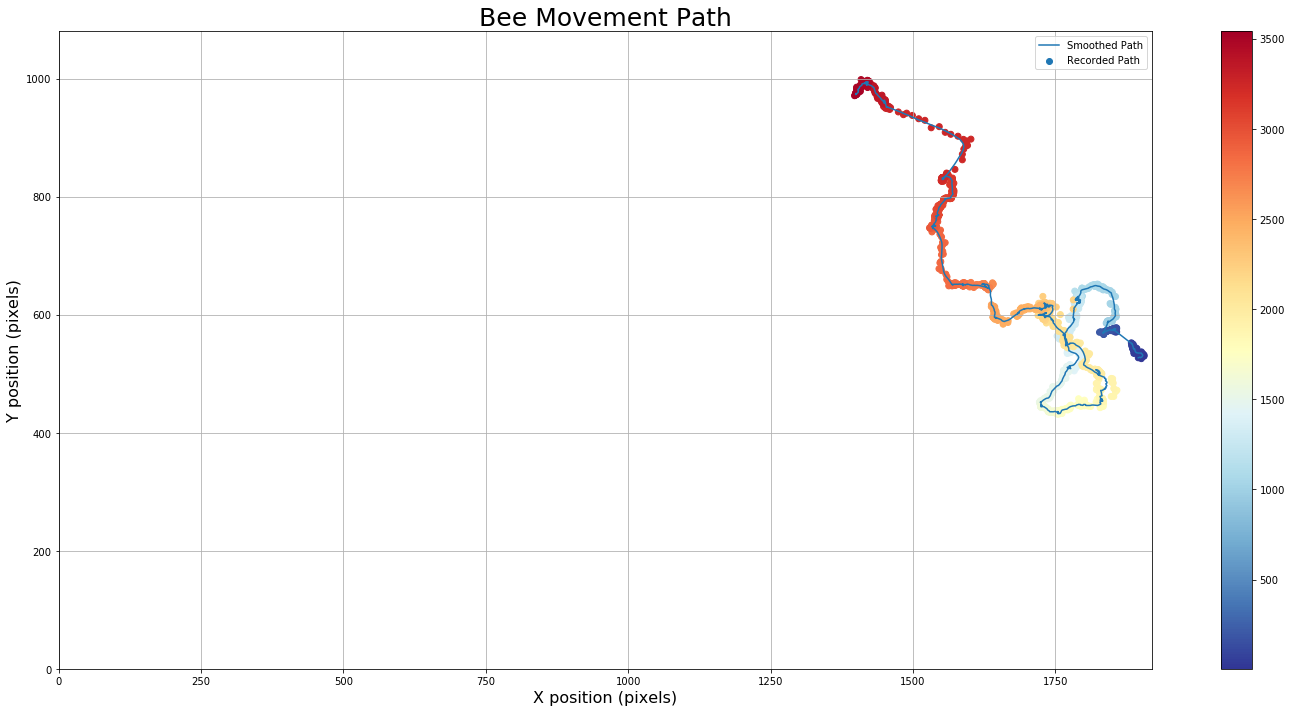

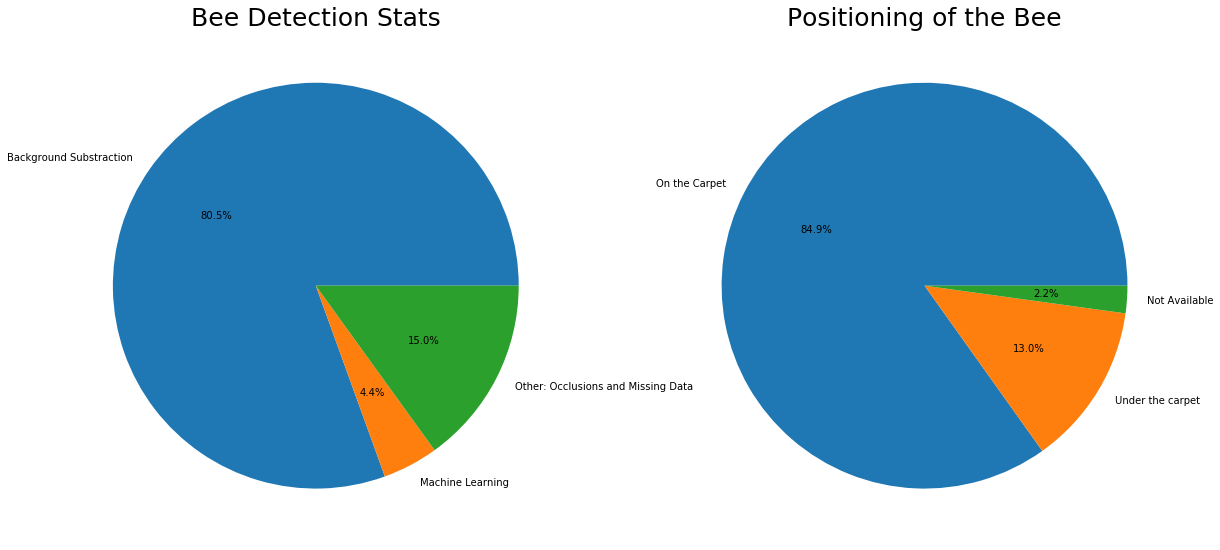

In [17]:
input_video = './input_video/bee_test_1.mp4'
output_video = './output/bee_test_1_out.avi'

cap = cv2.VideoCapture(input_video) 
fgbg = cv2.createBackgroundSubtractorKNN() #Use KNN background subtractor
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)   
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) 
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter(output_video,fourcc, 60.0, (int(width), int(height))) #Output video destination
df = pd.DataFrame(columns = ['nframe','x0','y0','area','x','y','occlusion','sx','sy','method','px','py','x0i','y0i','sx11','sy11','speed','speeds','angle','delta_area','mse_area','state'])
track_frame = np.zeros((1080,1920,3), np.uint8)
f= open("./output/video_details.txt","w+") #Print processing time to a file
f.write("Start:  " + start_time)
f.write("\n")
nframe = 1
# Check if video opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
while(cap.isOpened()):
  ret, frame = cap.read()
  if ret == True:
    #Run background subtraction to detect changes
    contours = Extract_cont(frame)
    bees = np.zeros(shape=(0,3))
    bg_changes =  np.zeros(shape=(0,3))
    details_frame = np.zeros((1080,1920,3), np.uint8)


    for c in contours:
        bees, bg_changes = detect_bees(nframe, bees, bg_changes, c, minframe)
        if (len(bees)>10): #If there are multiple changes in the frame, print a message
            print_message = 9

    #If an insect is detected, track the insect
    if ((int_detection ==True)):
        change_in_bg, nchanges = check_bg_changes(bg_changes,oldbees,max_jump_ML, max_bg_changes)
        cv2.putText(details_frame, 'Background Changes Detected: ' + str(nchanges -1) , (1400, 20), cv2.FONT_HERSHEY_DUPLEX , 0.8, (255, 255, 255), 1, cv2.LINE_AA)
        if ((len(bees)>0) & (change_in_bg ==False) & (missing == False)):
            dist_p2d, assignment = data_association(bees, oldbees)
            cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump), (255,255,120), 1)
            
            if (dist_p2d<=max_jump):
                print_message = 1
                occlusions,details_frame, track_frame = record_associated(nframe,details_frame,track_frame,  bees,oldbees,assignment,0, print_message)
                oldbees, details_frame = predict_position(prediction_method, details_frame)
                
            else:
                results, nbees, frame = detect_from_ML(nframe, frame, minConf)
                if (nbees>=1):
                    beeML = bee_coordinates(results, minConf)
                    dist_p2d, assignment = data_association(beeML, oldbees)
                    cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump_ML), (255,255,120), 1)
                    if (dist_p2d<=(max_jump_ML)):
                        print_message = 2
                        occlusions,details_frame, track_frame = record_associated(nframe,details_frame,track_frame,  beeML,oldbees, assignment,1,print_message)
                        oldbees, details_frame = predict_position(prediction_method, details_frame)
                        missing, state, bee_leave_prob, quantile = bee_found(missing, state, bee_leave_prob, quantile )
                                                
                    else:
                        missing, occlusions = missing_bee(nframe,oldbees, occlusions, missing, max_occlusions)
                        cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump_ML), (255,255,120), 1)
                        print_message = 3

                else:
                    missing, occlusions = missing_bee(nframe,oldbees, occlusions, missing, max_occlusions)
                    cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump_ML), (255,255,120), 1)
                    print_message = 4
        else:
            
            results, nbees, frame = detect_from_ML(nframe, frame, minConf)
            if (nbees>=1):
                beeML = bee_coordinates(results, minConf)
                dist_p2d, assignment = data_association(beeML, oldbees)
                cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump_ML), (255,255,120), 1)
                if (dist_p2d<=max_jump_ML):
                    print_message = 5
                    occlusions,details_frame, track_frame = record_associated(nframe,details_frame,track_frame,  beeML,oldbees, assignment,1, print_message)
                    oldbees, details_frame = predict_position(prediction_method, details_frame)
                    missing, state, bee_leave_prob, quantile  = bee_found(missing, state, bee_leave_prob, quantile )
                                         
                else:
                    missing, occlusions = missing_bee(nframe,oldbees, occlusions, missing, max_occlusions)
                    cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump_ML), (255,255,120), 1)
                    print_message = 6
            else:
                missing, occlusions = missing_bee(nframe,oldbees, occlusions, missing, max_occlusions)
                cv2.circle(details_frame, (int(oldbees[0][0]), int(oldbees[0][1])), int(max_jump_ML), (255,255,120), 1)
                print_message = 7
               
    #If an insect is occluded; run occlusion detection algorithm           
    if(missing):
        if (df.delta_area.count()>4):
            last_state = df.delta_area.iloc[(df.delta_area.last_valid_index())-3:(df.delta_area.last_valid_index())+1].mean()
        else:
            if (df.delta_area.count()>0):
                last_state = df.delta_area.iat[(df.delta_area.last_valid_index())]
            else:
                last_state = 10
        if((last_state < 0) & (nchanges<=max_bg_changes)):
            update_state()
            print_message = 8
            
            
        quantile, bee_leave_prob = check_position(occlusions, quantile,max_bee_leave_prob)
        details_frame = cv2.putText(details_frame, 'Bee leave Probability: ' + str(bee_leave_prob) + ' %' , (1400, 60), cv2.FONT_HERSHEY_DUPLEX , 0.8, (255, 255, 255), 1, cv2.LINE_AA)
        
        #If the insect has left the frame, start looking for a new insect to track; update parameters
        if (bee_leave_prob>=max_bee_leave_prob):
            bee_num+=1
            int_detection = False
            occlusions = 0
            change_in_bg = False
            missing = False
            bee_leave_prob  = 0
            state  = 0
            quantile =1
            print_message = 0
            minX,minY,maxX,maxY = 50,50,1870,1030
       
    #If an insect is not detected, look for changes in the forgreound/background to detect possible appearence
    if (int_detection == False):
        if (len(bg_changes)>0):
            results, nbees, frame = detect_from_ML_int(nframe, frame, minConf)
            if (nbees>=1):
                intbee = bee_coordinates_int(results, minConf)
                if (bee_num>0):
                    dist_new_old = cal_dist(df.x0.iat[(df.x0.last_valid_index())],df.y0.iat[(df.y0.last_valid_index())], intbee[0][0], intbee[0][1])
                    if (dist_new_old>max_jump_ML):
                        df =bee_has_left(bee_num,df)
                track_frame = add_int_record(track_frame,intbee,nframe)
                oldbees = intbee
                int_detection = True
    #update detection thresholds       
    max_jump, max_jump_ML = update_max_jump(max_jump_int, max_jump_ML_int, occlusions, data_threshold)

    
        
    #Display data on the frame
    details_frame = print_screen(nframe,details_frame,state,  occlusions, print_message)   
    details_frame = cv2.add(details_frame,track_frame)
    display_frame = cv2.add(frame, details_frame)

    out.write(display_frame)
    cv2.imshow("Output", display_frame)
    nframe+=1
 
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break
 
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows()
df = df.drop(df.index[(df.x0.last_valid_index()+1):(df.state.last_valid_index()+1)])
end_time = str(datetime.now())
f.write("End:  " + (end_time))
f.close() 
df.to_csv("./output/bee_test_1_track.csv", sep=',') #Save the csv file with insect track

plot_path()
draw_piechart()